In [1]:
import os
from help_func import *
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

### import scATAC-seq & scRNA-seq

In [2]:
ATAC_data = sc.read_h5ad('./Processed data/10X_pbmc_ATAC.h5ad')
ATAC_data

AnnData object with n_obs × n_vars = 10412 × 105949
    obs: 'celltype', 'n_genes'
    var: 'peak', 'gene', 'distance', 'peak_type', 'chr', 'from', 'to', 'n_cells'

In [3]:
RNA_data = sc.read_h5ad('./Processed data/10X_pbmc_RNA.h5ad')
RNA_data.var_names_make_unique()
RNA_data

AnnData object with n_obs × n_vars = 10412 × 21618
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

### filter CD14 Mono celltype

In [4]:
ATAC_data = filter_cells(ATAC_data, ATAC_data.obs[ATAC_data.obs['celltype']=='CD14 Mono'].index)
sc.pp.filter_cells(ATAC_data, min_genes=10)
sc.pp.filter_genes(ATAC_data, min_cells=1)
ATAC_data

AnnData object with n_obs × n_vars = 2789 × 105693
    obs: 'celltype', 'n_genes'
    var: 'peak', 'gene', 'distance', 'peak_type', 'chr', 'from', 'to', 'n_cells'

In [5]:
RNA_data = filter_cells(RNA_data, RNA_data.obs[RNA_data.obs['celltype']=='CD14 Mono'].index)
sc.pp.filter_cells(RNA_data, min_genes=10)
sc.pp.filter_genes(RNA_data, min_cells=1)
RNA_data

AnnData object with n_obs × n_vars = 2789 × 21306
    obs: 'celltype', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

#### import SCARP cell embedding, and clustering using Louvain

In [6]:
SCARP_cell_embedding = pd.read_csv('./Results/10X_pbmc_ATAC_SCARP_Cells_feature.csv', index_col=0)
SCARP_cell_embedding.head(2)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20
AAACAGCCAAGGAATC-1,0.933271,-0.283553,-0.062964,-0.140009,0.041229,-0.086540,-0.014717,-0.028216,-0.055984,0.025336,0.042145,0.006337,0.035778,0.018198,-0.053741,-0.000919,0.056348,0.002203,0.022861,-0.032236
AAACAGCCAATCCCTT-1,0.947859,-0.272906,-0.053383,0.021399,-0.026240,0.089406,0.022469,-0.010511,0.008358,0.002801,-0.069020,0.039730,-0.037164,-0.010340,0.026642,-0.015420,-0.050946,0.032170,0.035229,0.027465


In [7]:
adata_cell = sc.AnnData(SCARP_cell_embedding.loc[RNA_data.obs.index])
adata_cell.var_names_make_unique()
sc.pp.neighbors(adata_cell, use_rep='X', random_state=1)
sc.tl.umap(adata_cell, random_state=1)

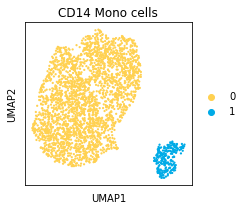

In [8]:
[warning, adata_cell] = getNClusters_Louvain(adata_cell, 2, range_max=3)
if warning == 0:
    print('Wrong for Louvain! ')
fig, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata_cell, color='louvain', 
           title='CD14 Mono cells', s=20, ax=ax, 
           save='_CD14_Mono_cells.svg',
           palette ={'0':'#FFD151',
                     '1':'#00ABE7'})

In [9]:
RNA_data.obs['louvain'] = adata_cell.obs['louvain'].loc[RNA_data.obs.index]
RNA_data.obsm = adata_cell.obsm

In [10]:
ATAC_data.obs['louvain'] = adata_cell.obs['louvain'].loc[ATAC_data.obs.index]
ATAC_data.obsm = adata_cell.obsm

### differential analysis for RNA

In [15]:
sc.pp.normalize_total(RNA_data)
sc.pp.log1p(RNA_data)
sc.pp.scale(RNA_data)
RNA_data

AnnData object with n_obs × n_vars = 2789 × 21306
    obs: 'celltype', 'n_genes', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_umap'

In [17]:
sc.tl.rank_genes_groups(RNA_data, 'louvain', method='wilcoxon')

In [18]:
RNA_DE_result = RNA_data.uns['rank_genes_groups']

In [19]:
RNA_DE_genes = pd.DataFrame(RNA_DE_result['names'])
RNA_DE_genes.head(5)

,0,1
0,DPYD,BCL11B
1,TYMP,SKAP1
2,NEAT1,CD247
3,FCN1,PRKCH
4,ARHGAP26,RPL3


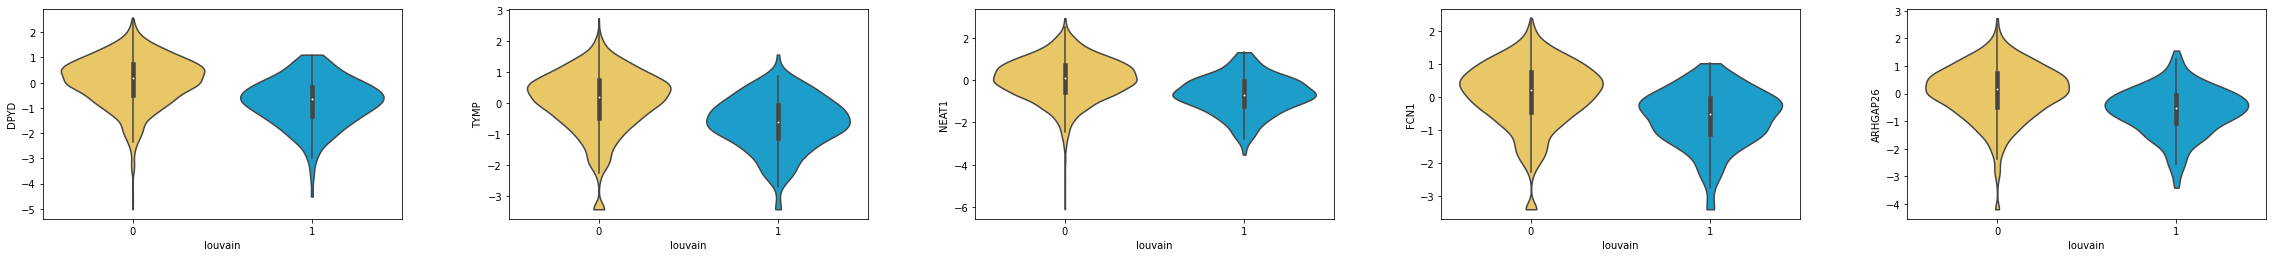

In [20]:
sc.pl.violin(RNA_data, list(RNA_DE_genes['0'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_RNA_CD14_Mono_violin_group0.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

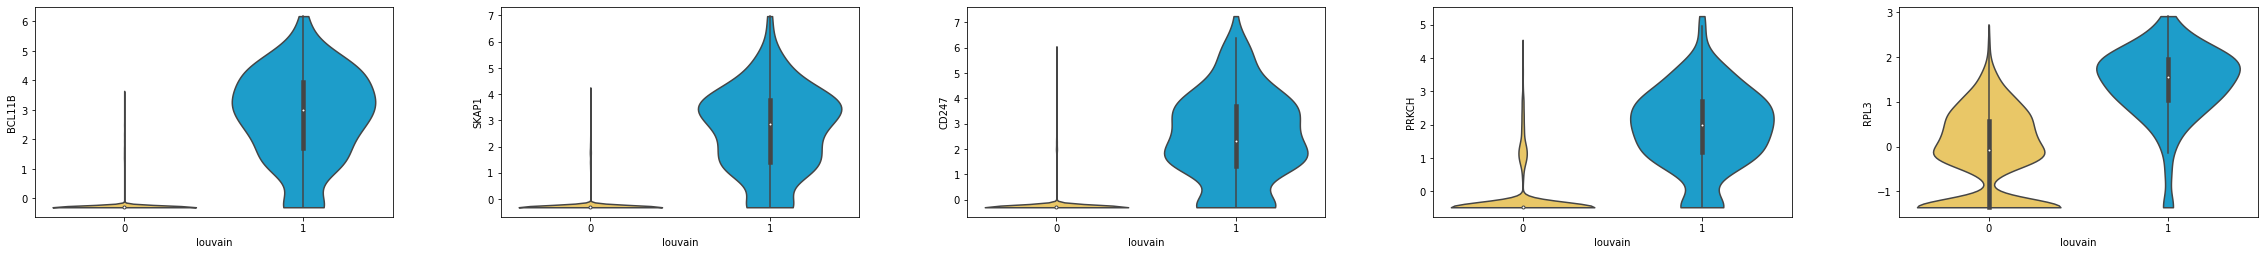

In [21]:
sc.pl.violin(RNA_data, list(RNA_DE_genes['1'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_RNA_CD14_Mono_violin_group1.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

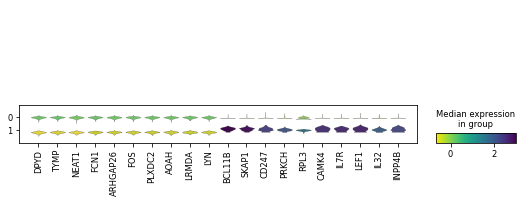

In [22]:
marker_genes = list(RNA_DE_genes['0'].iloc[0:10]) + list(RNA_DE_genes['1'].iloc[0:10])
sc.pl.stacked_violin(RNA_data, marker_genes, groupby='louvain',
                    save='_RNA_CD14Mono_marker_genes.svg',
                    cmap='viridis_r')

### differential analysis for ATAC

In [23]:
sc.pp.normalize_total(ATAC_data)
sc.pp.log1p(ATAC_data)
sc.pp.scale(ATAC_data)
ATAC_data

AnnData object with n_obs × n_vars = 2789 × 105693
    obs: 'celltype', 'n_genes', 'louvain'
    var: 'peak', 'gene', 'distance', 'peak_type', 'chr', 'from', 'to', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_umap'

In [24]:
sc.tl.rank_genes_groups(ATAC_data, 'louvain', method='wilcoxon')

In [25]:
ATAC_DE_result = ATAC_data.uns['rank_genes_groups']

In [26]:
ATAC_DE_peaks = pd.DataFrame(ATAC_DE_result['names'])
ATAC_DE_peaks.head(5)

,0,1
0,chr9:107480158-107492721,chr14:99255246-99275454
1,chr20:50269694-50277398,chr7:142782798-142813716
2,chr11:61953652-61974246,chr14:22536559-22563070
3,chr9:134369462-134387253,chr14:99223600-99254668
4,chr10:128045032-128071717,chr11:128462698-128485937


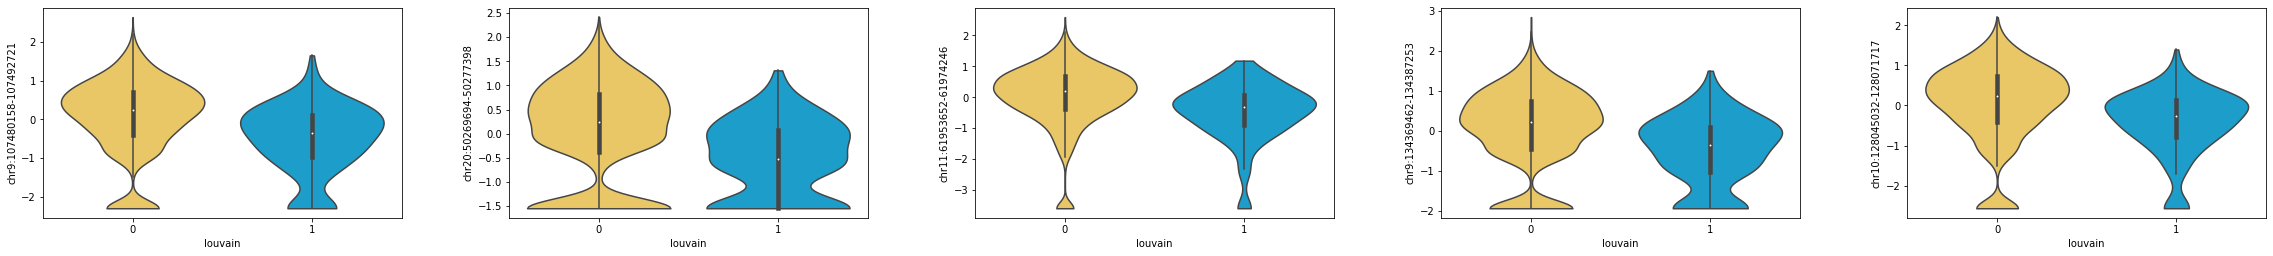

In [27]:
sc.pl.violin(ATAC_data, list(ATAC_DE_peaks['0'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_ATAC_CD14_Mono_violin_group0.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

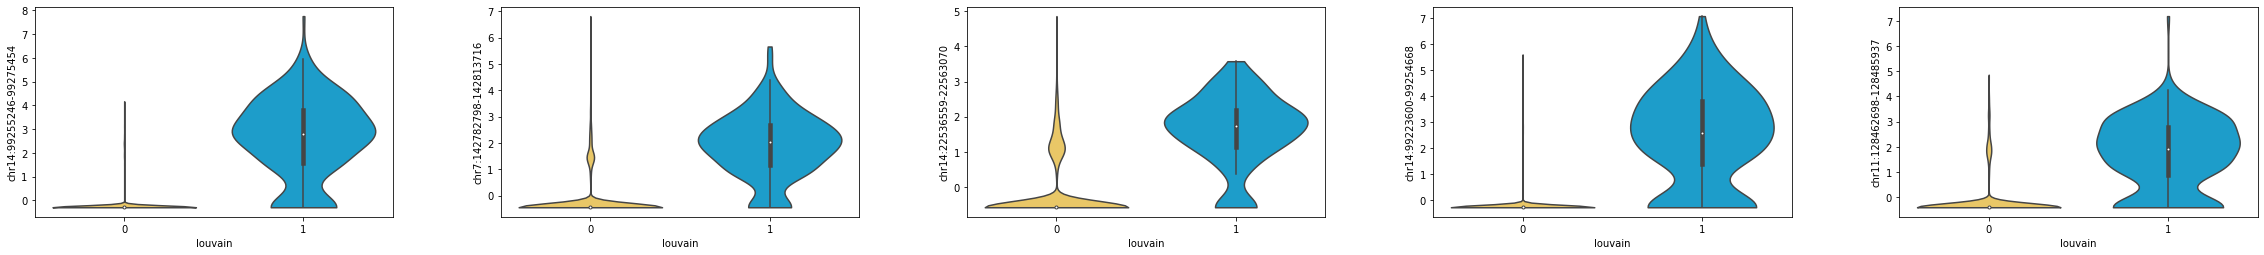

In [28]:
sc.pl.violin(ATAC_data, list(ATAC_DE_peaks['1'].iloc[0:5]), 
             groupby='louvain', stripplot=False, inner='box',
             save='_ATAC_CD14_Mono_violin_group1.svg',
             palette ={'0':'#FFD151',
                       '1':'#00ABE7'})

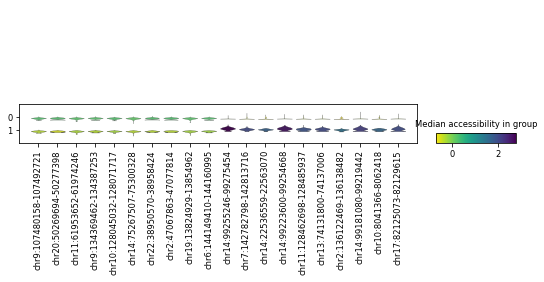

In [29]:
marker_peaks = list(ATAC_DE_peaks['0'].iloc[0:10]) + list(ATAC_DE_peaks['1'].iloc[0:10])
sc.pl.stacked_violin(ATAC_data, marker_peaks, groupby='louvain',cmap='viridis_r',
                    save='_ATAC_CD14_Mono_marker_peaks.svg',
                    colorbar_title ='Median accessibility in group')

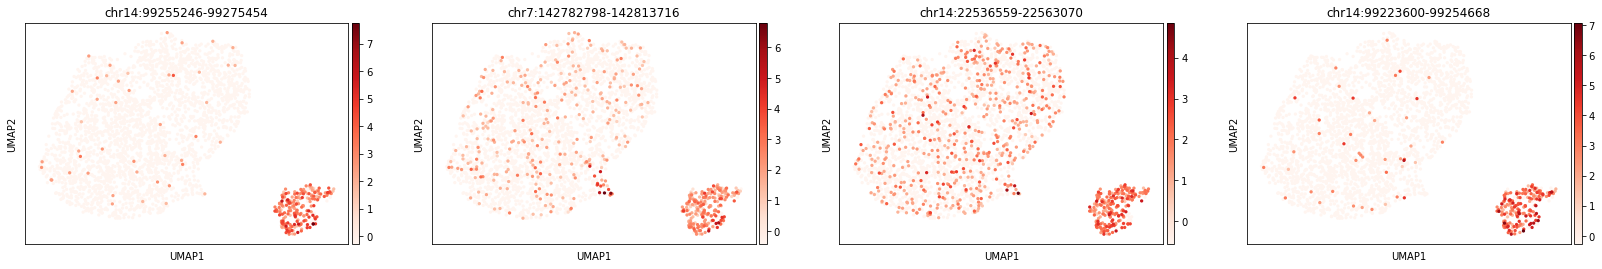

In [31]:
sc.pl.umap(ATAC_data, color=ATAC_DE_peaks['1'].iloc[0:4],
           color_map='Reds')

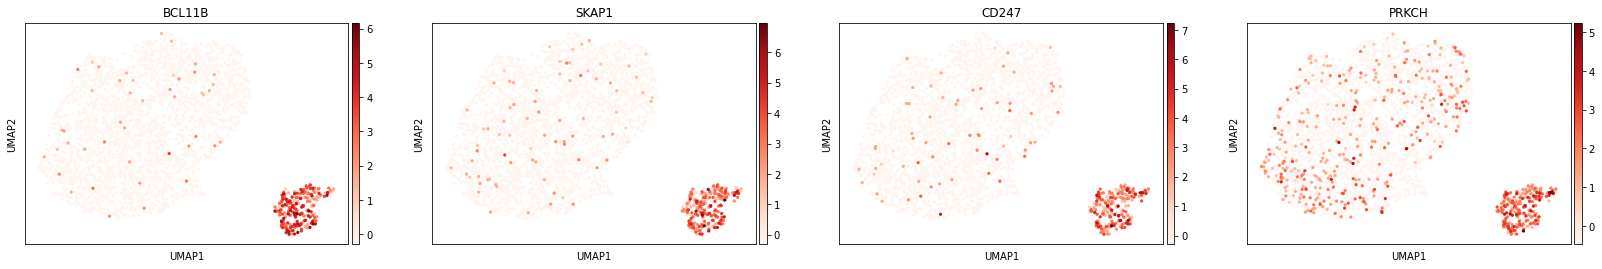

In [32]:
sc.pl.umap(RNA_data, color=RNA_DE_genes['1'].iloc[0:4],
           color_map='Reds')